# 0. 필요 패키지 로드 및 이미지 로드

In [ ]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import skimage
import time
import math
from skimage import img_as_bool
from tqdm.notebook import tqdm
import scipy
from math import sqrt
from scipy import signal
from scipy import ndimage
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import pandas as pd



In [ ]:
# 이미지 로드 및 grayscale transformation
img1 = cv2.imread('001_00.png', 0)
img2 = cv2.imread('002_00.png', 0)


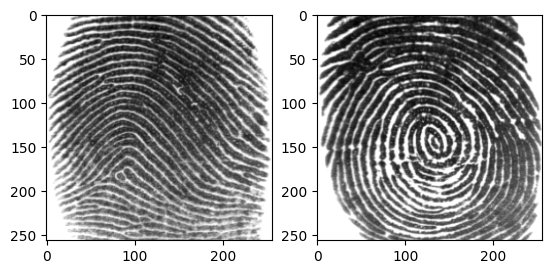

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')

# 1. 이미지 전처리

## 1.1 기타 전처리 없이 Binarization 및 Skeletonization

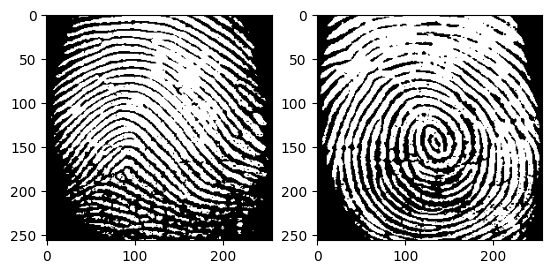

In [ ]:
def binarization(img):
  img_bin = np.zeros((256,256), dtype=np.uint8)
  img_bin[img>120] = 255
  img_bin = 255 - img_bin
  return img_bin

img1_bin = binarization(img1)
img2_bin = binarization(img2)
plt.subplot(1,2,1)
plt.imshow(img1_bin, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_bin, cmap='gray')

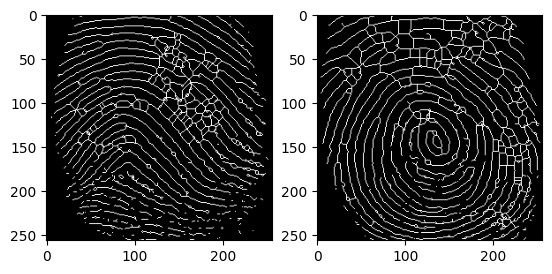

In [ ]:
def skeletonization(bin_img) :
  img_bin_bool = img_as_bool(bin_img)
  skeleton = skeletonize(img_bin_bool)
  img_skeleton = (skeleton * 255).astype(np.uint8)
  return img_skeleton

img1_skeleton = skeletonization(img1_bin)
img2_skeleton = skeletonization(img2_bin)
plt.subplot(1,2,1)
plt.imshow(img1_skeleton, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_skeleton, cmap='gray')

노이즈가 많아 특징점 추출에 문제가 생겨, 전처리 필터를 찾아보았다.
Gabor filter, Gaussian Blur, Median Blur, Bilateral Filter, NL-Means Filter, Binarization, Color Conversion, Morphology 연산, 적응이진화 등이 있다.  

지문인식의 핵심은 유효한 특징점 찾기다.
그점을 달성하기 위해서는
1. 원래 이어진 선 연결
2. 자잘한 점 제거
가 필요하다.


# 1.2 이미지 전처리과정 수행

**1.2.1 Image Nomalization**

능선(ridge)에 따라 gray level value의 variance(분산)을 줄이기 위해 수행한다.
이를 통해 subsequent process가 보다 원활히 처리 될 수 있다.  

Nomalization은 Aeraging --> Variance Caculation --> Caculating nomalized value 로 이루어진다.


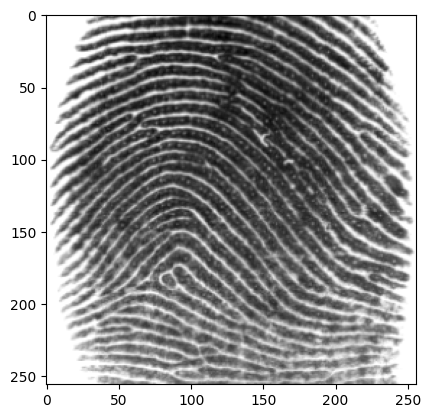

In [ ]:
def normalize(img, mean, std):
   normed = (img - np.mean(img)) / (np.std(img))
   return (normed)

normalized_img1 = normalize(img1,0,1)
plt.imshow(normalized_img1, cmap='gray')

**1.3.2 Segmentation**

유용한 부분과 노이즈 및 배경을 구분해야한다. 위 gray levels의 분산을 기반으로 계산한다. 블록을 나누어 각 블록의 root variance를 threshold와 비교하며 진행한다.

value < threshold , 배경으로 인식

Threshold 값은 0.1, 블록 사이즈 값은 3으로 하여 진행하였다.

In [ ]:
def ridge_segment(nomalization_img,block_size ):
        img = nomalization_img
        rows, cols = img.shape

        new_rows = int(block_size * np.ceil((float(rows)) / (float(block_size))))
        new_cols = int(block_size * np.ceil((float(cols)) / (float(block_size))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = img
        for i in range(0, new_rows, block_size):
            for j in range(0, new_cols, block_size):
                block = padded_img[i:i + block_size][:, j:j + block_size]

                stddevim[i:i + block_size][:, j:j + block_size] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        mask = stddevim > 0.1
        mean_val = np.mean(img[mask])
        std_val = np.std(img[mask])
        normim = (img - mean_val) / (std_val)
        return normim, mask

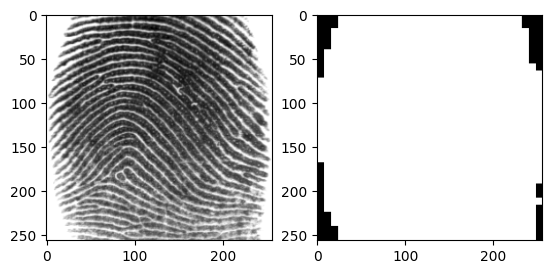

In [ ]:
norm_img1,mask_img1=ridge_segment(normalized_img1,8)
plt.subplot(1,2,1)
plt.imshow(norm_img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask_img1, cmap='gray')

**1.3.3 Spatial estimation of the directional map**

비어있는 공간에 대한 원래 ridge의 방향을 예측할 필요가 있다.
이를 위해 Gabor filtering을 이용할 것이다. Gabor filtering은 이미지 처리에 필요한 선명도 향상 기술 중 하나로 특정 방향 및 주파수를 가진 신호를 추출하고 그를 강조하는데 쓰인다.  

In [ ]:
# 방향 계산
def ridge_orient(norm_img, orient_smooth_sigma):
        rows,cols = norm_img.shape
        gradient_sigma=1
        sze = np.fix(6*gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv2.getGaussianKernel(int(sze),gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)
        #Gradient of Gaussian
        Gx = signal.convolve2d(norm_img, fx, mode='same')
        Gy = signal.convolve2d(norm_img, fy, mode='same')
        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*7)
        gauss = cv2.getGaussianKernel(int(sze), 7)
        f = gauss * gauss.T
        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom

        sze = np.fix(6*orient_smooth_sigma)
        if np.remainder(sze,2) == 0:
          sze = sze+1
        gauss = cv2.getGaussianKernel(int(sze), orient_smooth_sigma)
        f = gauss * gauss.T
        cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
        sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2
        return orientim

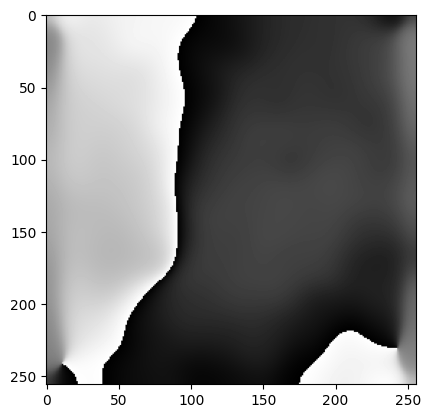

In [ ]:
orient_img1 = ridge_orient(norm_img1,7)
plt.imshow(orient_img1,cmap='gray')

In [ ]:
# ridge frequency 계산

def ridge_freq(norm_img, orient_img, mask):
        ridge_freq_blksze = 38
        rows, cols = norm_img.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - ridge_freq_blksze, ridge_freq_blksze):
            for c in range(0, cols - ridge_freq_blksze, ridge_freq_blksze):
                blkim = norm_img[r:r + ridge_freq_blksze][:, c:c + ridge_freq_blksze]
                blkor = orient_img[r:r + ridge_freq_blksze][:, c:c + ridge_freq_blksze]

                freq[r:r + ridge_freq_blksze][:, c:c + ridge_freq_blksze] = frequest(blkim, blkor)

        freq = freq * mask
        freq_1d = np.reshape(freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        mean_freq = np.mean(non_zero_elems_in_freq)

        freq = mean_freq * mask
        return freq , mean_freq

def frequest(blkim, blkor):
        min_wave_length= 5
        max_wave_length =15
        ridge_freq_windsze = 5
        rows, cols = np.shape(blkim)
        # 블록의 평균 방향을 찾는다.
        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        # ridge가 수직이 되도록 돌린다.
        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        # 정상 값을 가지도록 한다.
        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        # projection
        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, ridge_freq_windsze, structure=np.ones(ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        # Determine the spatial frequency of the ridges by divinding the
        # distance between the 1st and last peaks by the (No of peaks-1). If no
        # peaks are detected, or the wavelength is outside the allowed bounds,
        # the frequency image is set to 0

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= min_wave_length and waveLength <= max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

In [ ]:
def ridge_filter(norm_img,orient_img,freq):
        kx=0.65
        ky=0.65
        angleInc = 3
        ridge_filter_thresh = -3
        im = np.double(norm_img)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))
        freq_1d = np.reshape(freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)
        ind = np.array(ind)
        ind = ind[1, :]

        # 효율적인 연산을 위한 반올림
        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100
        unfreq = np.unique(non_zero_elems_in_freq)

        # 필터 생성

        sigmax = 1 / unfreq[0] * kx
        sigmay = 1 / unfreq[0] * ky
        sze = int(np.round(3 * np.max([sigmax, sigmay])))
        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        # original gabor filter
        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)
        filt_rows, filt_cols = reffilter.shape

        angleRange = int(180 /angleInc)
        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):
            rot_filt = scipy.ndimage.rotate(reffilter, -(o * angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # 경계 찾기
        maxsze = int(sze)
        temp = freq > 0
        validr, validc = np.where(temp)
        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze
        final_temp = temp1 & temp2 & temp3 & temp4
        finalind = np.where(final_temp)

        # 라디안값을 index value로 변환

        maxorientindex = np.round(180 / angleInc)
        orientindex = np.round(orient_img / np.pi * 180 / angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        binim = newim < ridge_filter_thresh
        binim= (binim*255).astype(np.uint8)
        return binim

In [ ]:
freq_img1, mean_freq_img1 = ridge_freq(norm_img1, orient_img1, mask_img1)
bin_img1 =ridge_filter(norm_img1,orient_img1,freq_img1)

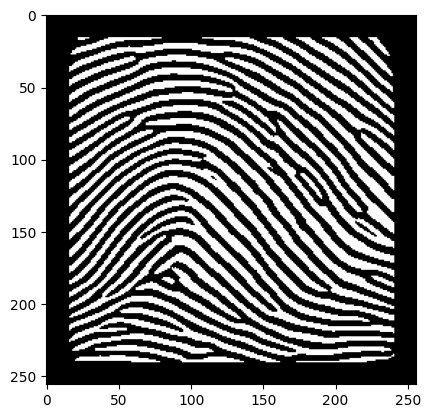

In [ ]:
plt.imshow(bin_img1, cmap='gray')

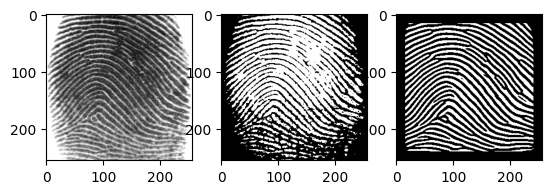

In [ ]:
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img1_bin, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(bin_img1, cmap='gray')

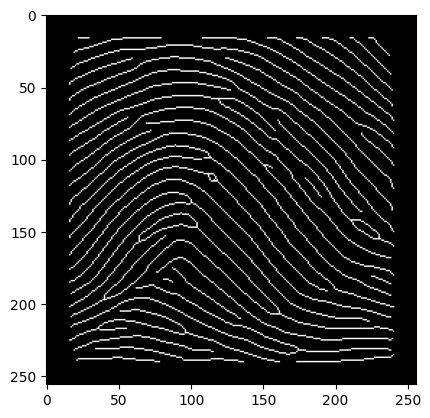

In [ ]:
s=skeletonization(bin_img1)
plt.imshow(s, cmap='gray')

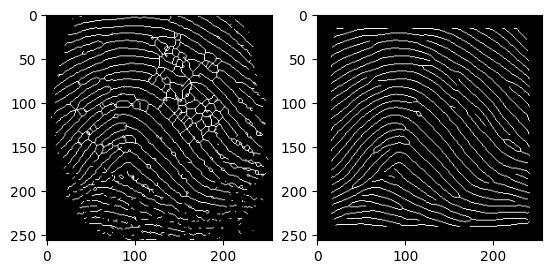

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img1_skeleton, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(s, cmap='gray')

# 2. 특징추출

In [ ]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation

class FingerprintFeatureExtractor(object):
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh =10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def getskel(self, skel):
        self._skel = skel

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if (minutiaeType.lower() == 'termination'):
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if (sumVal > 1):
                            angle.append(float('nan'))
            return (angle)

        elif (minutiaeType.lower() == 'bifurcation'):
            (blkRows, blkCols) = np.shape(block)
            CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if (sumVal != 3):
                angle.append(float('nan'))
            return (angle)

    def __getTerminationBifurcation(self,img):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if (self._skel[i][j] == 1):
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if (block_val == 2):
                        self.minutiaeTerm[i, j] = 1
                    elif (block_val == 4):
                        self.minutiaeBif[i, j] = 1
        self._mask = img*255
        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))  # Structuing element for mask erosion = square(5)
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2)
                D[i][j] = dist
                if(dist < self._spuriousMinutiaeThresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid'])
                img[X,Y] = 1

        img = np.uint8(img)
        return(img)

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 1
        FeaturesTerm = []
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if(len(angle) == 1):
                FeaturesTerm.append(MinutiaeFeature(row, col, angle))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if(len(angle) == 3):
                FeaturesBif.append(MinutiaeFeature(row, col, angle))
        return (FeaturesTerm, FeaturesBif)

    def extractMinutiaeFeatures(self, img):

        self.__getTerminationBifurcation(img)

        self.__cleanMinutiae(img)

        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return(FeaturesTerm, FeaturesBif)

    def showResults(self, FeaturesTerm, FeaturesBif):

        (rows, cols) = self._skel.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = 255*self._skel
        DispImg[:, :, 1] = 255*self._skel
        DispImg[:, :, 2] = 255*self._skel

        for idx, curr_minutiae in enumerate(FeaturesTerm):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))

        for idx, curr_minutiae in enumerate(FeaturesBif):
            row, col = curr_minutiae.locX, curr_minutiae.locY
            (rr, cc) = skimage.draw.circle_perimeter(row, col, 3)
            skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))

        plt.imshow(DispImg)



def extract_minutiae_features(img,skel, spuriousMinutiaeThresh=10, showResult=False):
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)
    feature_extractor.getskel(skel)
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(img)

    if(showResult):
        feature_extractor.showResults(FeaturesTerm, FeaturesBif)

    return(FeaturesTerm, FeaturesBif)

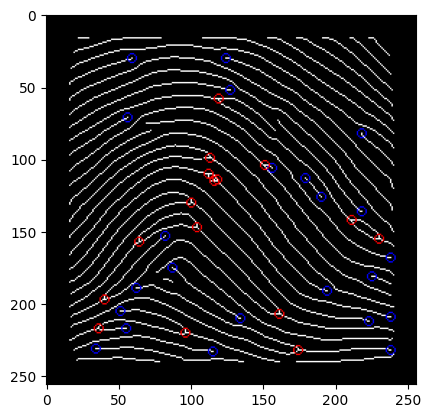

In [ ]:
FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(bin_img1,s,spuriousMinutiaeThresh=9,  showResult=True)

In [ ]:
def features_to_matrix(features):
    matrix = np.zeros((len(features), 2),np.uint8)
    for i, f in enumerate(features):
        matrix[i, 0] = f.locX
        matrix[i, 1] = f.locY
    return matrix

In [ ]:
#하나로 묶기
def get_point(img) :
    normalized_img = normalize(img,0,1)
    norm_img,mask_img=ridge_segment(normalized_img,8)
    orient_img = ridge_orient(norm_img,7)
    freq_img,_ = ridge_freq(norm_img, orient_img, mask_img)
    bin_img =ridge_filter(norm_img,orient_img,freq_img)
    s=skeletonization(bin_img)
    FeaturesTerminations, FeaturesBifurcations = extract_minutiae_features(bin_img1,s,spuriousMinutiaeThresh=9,  showResult=False)
    ter = features_to_matrix(FeaturesTerminations)
    bif = features_to_matrix(FeaturesBifurcations)
    return ter, bif

In [ ]:
%%time
get_point(img1)

CPU times: user 1.84 s, sys: 46.2 ms, total: 1.89 s
Wall time: 1.87 s


(array([[ 30,  59],
        [ 30, 124],
        [ 52, 127],
        [ 71,  56],
        [ 82, 218],
        [106, 156],
        [113, 179],
        [126, 190],
        [136, 218],
        [153,  82],
        [168, 238],
        [175,  87],
        [181, 225],
        [189,  62],
        [191, 194],
        [205,  51],
        [209, 238],
        [210, 134],
        [212, 223],
        [217,  55],
        [231,  34],
        [232, 238],
        [233, 115]], dtype=uint8),
 array([[ 58, 119],
        [ 99, 113],
        [104, 151],
        [110, 112],
        [114, 118],
        [115, 116],
        [130, 100],
        [142, 211],
        [147, 104],
        [155, 230],
        [157,  64],
        [197,  40],
        [207, 161],
        [217,  36],
        [220,  96],
        [232, 174]], dtype=uint8))

실행시간은 사진 하나당 약 1.85초가 나온다.
사실 노트북이 고장이나서 하드웨어적으로 현재 문제가 있는 상태이다. 그러나 현재 수리할 수 있는 상황이 아니므로 소프트웨어적으로 해결할 방법을 모색해보았다.

1. 이미지의 평균과 표준편차를 사용하여 정규화 하였다.
2. 사진 크기가 모두 256x256이므로 크기값을 하드코딩 할 수 있다.

#3. 매칭

In [ ]:
import zipfile

with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('/content/test2.zip', 'r') as zip_ref:
    zip_ref.extractall('test')

In [ ]:
train_path = '/content/train/train_ref'
test2_path = '/content/test/test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))


477 1428


In [ ]:
def match(train_ter,train_bif, test_ter,test_bif) :
    threshold = 25
    train_minutiae = np.vstack((train_ter, train_bif))
    test_minutiae = np.vstack((test_ter, test_bif))
    matched_pairs = []
    distances = []

    for m1 in train_minutiae:
        min_distance = np.min(np.linalg.norm(test_minutiae - m1, axis=1))
        if min_distance < threshold:
             matched_pairs.append((m1, test_minutiae[np.argmin(np.linalg.norm(test_minutiae - m1, axis=1))]))
             distances.append(min_distance)

    match_score = len(matched_pairs)*2 / (len(train_minutiae) + len(test_minutiae))*100
    final_distance = np.mean(distances)
    return match_score,final_distance


In [ ]:
dict_train={}
for t in tqdm(list_train):
    basename = os.path.basename(t)
    img_train = cv2.imread(t,0)
    db_x_end, db_x_bif = get_point(img_train)
    dict_train[basename] = [db_x_end, db_x_bif]

  0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
dict_test = {}
for t in tqdm(list_test2):
    basename = os.path.basename(t).split('_')[0]
    img_test = cv2.imread(t,0)
    te, tb = get_point(img_test)
    de = dict_train[basename+'.BMP'][0]
    db = dict_train[basename+'.BMP'][1]
    score,dist = match (de,db,te,tb)
    dict_test[t] = [score,dist]


  0%|          | 0/1428 [00:00<?, ?it/s]

In [ ]:
with open("dict_train.txt", "w") as f:
    for key, value in dict_train.items():
        f.write(f"{key}: {value}\n")

In [ ]:
def match_loop (test_end,test_bif) :
    dict_result = {}
    for t in tqdm(list_train):
      basename = os.path.basename(t).split('_')[0]
      img_train = cv2.imread(t,0)
      db_x_end, db_x_bif = get_point(img_train)
      score, dist = match (db_x_end,db_x_bif,test_end,test_bif)
      dict_result[basename] = [score ,dist]
    return dict_result


img_test = cv2.imread(list_test2[0],0)
te, tb = get_point(img_test)
result = pd.DataFrame(match_loop(te, tb))
result.to_csv('false1.txt', sep='\t', index=False)
print (result)


  0%|          | 0/477 [00:00<?, ?it/s]

       1.BMP     10.BMP    100.BMP    101.BMP    102.BMP    104.BMP  \
0  34.782609  38.888889  86.725664  36.974790  33.333333  31.067961   
1  12.632317  16.046913   1.009536  15.027982  14.644325  14.695227   

     105.BMP   106.BMP    107.BMP    108.BMP  ...     89.BMP      9.BMP  \
0  38.938053  54.00000  53.448276  29.310345  ...  43.859649  32.967033   
1  14.591095  13.47046  14.206896  15.810061  ...  13.464181  14.109824   

      90.BMP     93.BMP     94.BMP     95.BMP    96.BMP     97.BMP     98.BMP  \
0  31.578947  36.521739  18.947368  42.735043  49.57265  28.318584  36.842105   
1  12.928373  15.003246  17.693883  16.862765  14.26503  12.817329  16.686700   

      99.BMP  
0  34.782609  
1  15.380800  

[2 rows x 477 columns]


In [ ]:
  img_test2 = cv2.imread(list_test2[4],0)
  te, tb = get_point(img_test)
  result = pd.DataFrame(match_loop(te, tb))
  result.to_csv('false2.txt', sep='\t', index=False)
  print (result)

  0%|          | 0/477 [00:00<?, ?it/s]

       1.BMP     10.BMP    100.BMP    101.BMP    102.BMP    104.BMP  \
0  50.000000  30.476190  43.636364  87.931034  34.285714  38.000000   
1  12.878175  15.598811  16.623964   2.482498  12.270930  14.511164   

     105.BMP    106.BMP    107.BMP    108.BMP  ...     89.BMP      9.BMP  \
0  40.000000  35.051546  47.787611  33.628319  ...  32.432432  38.636364   
1  15.894866  16.373483  16.374535  16.192110  ...  10.925454  13.929583   

      90.BMP     93.BMP     94.BMP     95.BMP     96.BMP     97.BMP  \
0  32.608696  25.000000  34.782609  31.578947  38.596491  30.909091   
1  14.579615  16.668492  15.272596  15.901459  13.564622  14.426392   

      98.BMP     99.BMP  
0  34.234234  39.285714  
1  14.644680  15.147271  

[2 rows x 477 columns]


In [ ]:
print(list_test2[0])
print(list_test2[4])

/content/test/test2/100_type1.BMP
/content/test/test2/101_type2.BMP


In [ ]:
data = "50.0	30.476190476190478	43.63636363636363	87.93103448275862	34.285714285714285	38.0	40.0	35.051546391752574	47.78761061946903	33.6283185840708	34.69387755102041	42.857142857142854	40.35087719298245	30.909090909090907	39.285714285714285	60.0	26.548672566371685	42.96296296296296	40.0	40.0	28.037383177570092	47.27272727272727	36.0	27.27272727272727	48.275862068965516	36.17021276595745	33.663366336633665	34.48275862068966	44.85981308411215	31.683168316831683	40.33613445378151	40.44943820224719	35.294117647058826	29.78723404255319	55.55555555555556	38.53211009174312	33.92857142857143	47.42268041237113	21.176470588235293	19.565217391304348	42.857142857142854	35.55555555555556	34.285714285714285	41.81818181818181	31.11111111111111	36.89320388349515	24.761904761904763	35.294117647058826	40.0	43.13725490196079	44.44444444444444	36.97478991596639	38.46153846153847	47.78761061946903	42.47787610619469	38.18181818181819	54.736842105263165	30.434782608695656	38.655462184873954	43.80952380952381	46.846846846846844	38.53211009174312	54.20560747663551	43.90243902439025	52.892561983471076	30.0	34.234234234234236	13.186813186813188	10.81081081081081	38.01652892561984	24.561403508771928	36.36363636363637	51.908396946564885	42.99065420560748	42.10526315789473	40.65040650406504	30.0	23.157894736842106	38.095238095238095	32.075471698113205	31.858407079646017	20.224719101123593	42.27642276422765	32.78688524590164	25.0	44.44444444444444	33.00970873786408	26.0	26.666666666666668	26.41509433962264	33.64485981308411	34.234234234234236	36.03603603603604	36.89320388349515	45.04504504504504	41.07142857142857	46.15384615384615	41.1214953271028	60.19417475728155	35.84905660377358	49.122807017543856	28.82882882882883	36.55913978494624	36.36363636363637	46.2962962962963	30.927835051546392	33.33333333333333	38.26086956521739	48.888888888888886	44.06779661016949	32.608695652173914	36.84210526315789	34.04255319148936	16.666666666666664	51.5625	37.735849056603776	46.15384615384615	47.27272727272727	42.99065420560748	33.92857142857143	31.25	35.64356435643564	47.2972972972973	33.33333333333333	26.41509433962264	52.63157894736842	41.23711340206185	39.37007874015748	52.94117647058824	36.95652173913043	27.350427350427353	22.018348623853214	40.0	35.41666666666667	42.97520661157025	42.62295081967213	18.823529411764707	39.66942148760331	17.02127659574468	42.3728813559322	39.31623931623932	44.85981308411215	34.40860215053764	40.0	41.44144144144144	32.6530612244898	31.858407079646017	41.32231404958678	44.06779661016949	40.38461538461539	38.88888888888889	46.400000000000006	26.373626373626376	45.45454545454545	43.63636363636363	33.64485981308411	35.18518518518518	42.592592592592595	30.0	28.57142857142857	49.54128440366973	27.27272727272727	35.64356435643564	38.88888888888889	38.46153846153847	49.01960784313725	26.785714285714285	55.44554455445545	28.26086956521739	21.052631578947366	58.71559633027523	31.19266055045872	45.714285714285715	44.230769230769226	44.26229508196721	37.03703703703704	47.524752475247524	43.47826086956522	39.285714285714285	46.666666666666664	46.0	46.616541353383454	52.336448598130836	37.83783783783784	36.03603603603604	42.016806722689076	28.31858407079646	32.0	33.33333333333333	18.39080459770115	31.06796116504854	34.862385321100916	57.65765765765766	50.45045045045045	38.46153846153847	42.71844660194174	42.857142857142854	38.095238095238095	32.98969072164948	32.608695652173914	36.17021276595745	40.0	27.586206896551722	44.827586206896555	37.254901960784316	31.25	36.0	35.051546391752574	27.722772277227726	28.82882882882883	25.742574257425744	44.06779661016949	24.444444444444443	33.00970873786408	32.323232323232325	52.892561983471076	40.38461538461539	44.03669724770643	32.6530612244898	29.213483146067414	38.18181818181819	42.99065420560748	53.333333333333336	29.47368421052631	40.0	39.34426229508197	26.548672566371685	24.489795918367346	37.03703703703704	37.5	38.0	46.464646464646464	27.184466019417474	48.148148148148145	36.0	40.77669902912621	36.52173913043478	20.408163265306122	44.44444444444444	33.00970873786408	40.4040404040404	45.28301886792453	20.618556701030926	49.18032786885246	50.943396226415096	31.46067415730337	21.73913043478261	35.294117647058826	47.27272727272727	27.77777777777778	48.214285714285715	33.33333333333333	33.33333333333333	35.64356435643564	48.07692307692308	41.37931034482759	25.225225225225223	34.78260869565217	28.09917355371901	38.83495145631068	29.059829059829063	46.846846846846844	27.77777777777778	45.04504504504504	25.581395348837212	41.904761904761905	33.6283185840708	26.96629213483146	34.34343434343434	56.71641791044776	23.52941176470588	26.923076923076923	27.184466019417474	30.107526881720432	49.23076923076923	23.52941176470588	27.27272727272727	44.44444444444444	33.33333333333333	33.87096774193548	62.96296296296296	46.42857142857143	27.522935779816514	36.97478991596639	42.592592592592595	56.41025641025641	42.0	45.614035087719294	33.02752293577982	30.476190476190478	31.372549019607842	31.57894736842105	38.775510204081634	48.275862068965516	51.37614678899083	36.03603603603604	36.53846153846153	33.00970873786408	35.39823008849557	30.612244897959183	31.11111111111111	41.17647058823529	26.804123711340207	44.89795918367347	33.33333333333333	40.0	37.62376237623762	27.522935779816514	38.0	28.28282828282828	22.68041237113402	15.238095238095239	32.142857142857146	28.57142857142857	34.862385321100916	29.166666666666668	41.584158415841586	47.05882352941176	39.21568627450981	44.44444444444444	44.642857142857146	31.06796116504854	39.25233644859813	39.25233644859813	33.6283185840708	32.6530612244898	37.254901960784316	38.38383838383838	21.978021978021978	38.26086956521739	45.588235294117645	39.25233644859813	38.297872340425535	25.925925925925924	25.806451612903224	28.037383177570092	46.728971962616825	32.38095238095238	34.95145631067961	38.83495145631068	34.862385321100916	34.54545454545455	28.28282828282828	35.8974358974359	38.095238095238095	25.806451612903224	37.16814159292036	35.714285714285715	49.01960784313725	33.33333333333333	27.77777777777778	40.816326530612244	42.201834862385326	31.666666666666664	42.3728813559322	46.93877551020408	46.774193548387096	25.263157894736842	30.927835051546392	35.84905660377358	33.33333333333333	40.38461538461539	45.28301886792453	39.34426229508197	30.76923076923077	31.666666666666664	26.666666666666668	35.294117647058826	37.38317757009346	30.76923076923077	38.095238095238095	40.74074074074074	45.714285714285715	51.37614678899083	34.0	27.450980392156865	40.74074074074074	21.052631578947366	38.18181818181819	52.94117647058824	46.808510638297875	21.73913043478261	65.27777777777779	43.54838709677419	38.53211009174312	37.735849056603776	31.683168316831683	43.24324324324324	40.38461538461539	30.476190476190478	23.300970873786408	49.01960784313725	32.18390804597701	42.42424242424242	28.57142857142857	38.095238095238095	52.63157894736842	44.66019417475729	37.254901960784316	39.62264150943396	36.734693877551024	37.62376237623762	20.2020202020202	34.92063492063492	37.83783783783784	39.6551724137931	45.09803921568628	40.38461538461539	33.02752293577982	30.357142857142854	31.683168316831683	55.85585585585585	28.8135593220339	41.23711340206185	39.62264150943396	23.423423423423422	19.565217391304348	50.79365079365079	23.300970873786408	44.24778761061947	33.9622641509434	38.0	37.5	41.17647058823529	27.956989247311824	32.6530612244898	36.22047244094488	36.206896551724135	24.742268041237114	42.10526315789473	50.0	52.77777777777778	35.64356435643564	40.816326530612244	46.715328467153284	37.89473684210527	32.323232323232325	26.804123711340207	22.916666666666664	41.509433962264154	42.30769230769231	35.294117647058826	57.42574257425742	47.524752475247524	42.201834862385326	42.71844660194174	50.43478260869565	36.84210526315789	41.07142857142857	43.859649122807014	36.19047619047619	41.75824175824176	37.254901960784316	40.707964601769916	48.64864864864865	38.46153846153847	29.268292682926827	33.64485981308411	28.000000000000004	33.61344537815126	43.24324324324324	55.35714285714286	34.862385321100916	36.734693877551024	30.927835051546392	40.77669902912621	35.051546391752574	32.432432432432435	38.63636363636363	32.608695652173914	25.0	34.78260869565217	31.57894736842105	38.59649122807017	30.909090909090907	34.234234234234236	39.285714285714285"
data_list = [float(x) for x in data.split()]
result = [x for x in data_list if x >= 50]
len(result)

35

In [ ]:
data = "12.632316848792001	16.0469134978731	1.009536392688421	15.027981714890364	14.644324735406858	14.695227340340754	14.591094737870238	13.470460089550274	14.206895518520138	15.810060610405374	12.547623409753454	12.626984251027613	13.25513966565496	14.166444493430753	14.547684849576257	15.213236324825044	17.722905604221122	14.225816442444145	16.895525702877258	13.419061726369405	15.367733308887015	13.25338890265578	14.2178708023088	15.165124607933375	12.99367642318802	13.14121228228056	17.418723755475835	15.023521990123701	15.87157199101594	14.333517105023956	16.8961770803066	11.03454157526504	12.914167051464869	14.936222191525786	15.691078171537574	12.806996216338362	15.68101204979846	14.885389360454655	14.483235419382993	13.695973005739155	12.349153378554288	11.934905412088114	11.200531537180945	12.691698639676375	12.666708203705335	14.101344568765226	14.593258178010204	13.185486855122964	14.000382642825278	14.976430407239928	12.536373134429674	13.227513557654795	15.36591542341137	15.265365547541823	16.25192606823464	13.621900931529106	16.957252953130187	13.93832466355371	17.527047332133417	18.302556228921716	12.969041190107587	15.846664780966154	15.345253073904903	14.8107813253349	13.455193857394145	14.303570541669446	15.209891162690134	13.565903589484396	15.549565748092732	13.268164334821076	15.2621979817069	14.23099670183564	13.617415819823696	15.413470247678802	15.395102330923786	14.36361361225162	14.960602534866547	13.840109547507542	14.543256685667615	15.993484787886485	15.960644390669472	15.194446873599418	15.70982502946301	15.69081460703133	10.917573049607974	14.018840274521779	14.421261106029782	15.422132007770676	12.02300486057118	12.386006731979592	13.825579366133722	14.630315379425776	11.380658785543517	12.277060438286217	14.600128675042201	13.065181697963393	14.073484172786952	15.094837183166613	14.63159165960114	14.877046907012952	15.441730293273881	12.847490980858815	15.966117694129597	14.450226242022326	13.697564497436732	17.857421889803902	12.899397939641036	12.508890772575171	16.511981384223105	15.989325273369246	14.887755980478715	12.546667983243376	16.16679590369104	14.449322409802202	15.97644285107427	15.631699975646175	15.921841304078939	13.535227298412808	13.857490613498761	15.245073477248802	16.236122364748827	15.864110272715756	15.284246263847507	12.983822168331281	11.967000354444139	15.631625672640766	15.513557530122155	11.833080551144889	13.935927202808763	14.713027536671916	13.017331518334972	12.452121204192343	12.349901509388655	16.54065654588033	14.160737574160379	14.613549339558801	16.27041810882937	14.482413196040941	16.65912118097692	17.3290330941765	15.199318581520973	11.139021996342239	14.166555053173559	14.274432323756514	12.974767346460597	16.21159932344002	13.655034307149451	11.900548860130927	14.79497073992451	15.408615147254727	11.649908342174259	16.06037900469137	14.342815161968305	14.550077731583745	15.0644019332977	17.504431884455265	13.067668535728627	15.576382863262799	11.762789995897805	14.389994722763786	14.48211825891181	11.962859164698804	17.36691055659746	13.272458434524111	12.525849860744543	13.036183664694255	16.21856712821119	13.438137909719408	11.974324644981406	17.129518167486022	13.383869678079781	12.693667791189293	12.298893147990977	15.544795058781006	12.791484589134381	14.57237163588079	16.15834275045446	15.920747413959429	13.850575597350304	16.16961165281305	16.279086026914968	14.652567713929695	11.731610915582523	13.193169345745016	15.991506527950415	12.953631972928905	14.419146656783798	15.09551995307585	13.698247945507799	15.79247841435074	10.610077171301553	12.500928017376898	15.868138196900517	14.089650668663126	13.814151013385537	13.885981036318313	13.953227349478947	14.828635214610529	14.218727780822602	16.158620053540467	15.532679215146686	14.051755205328107	15.168321928874162	14.330339249416001	16.67209059179536	11.693967758531683	16.712663760662007	13.471587091611454	16.301847168225116	15.455776300700908	11.777453607012875	15.912577018695401	13.248740719085617	13.495294398335801	13.26088920236028	14.828552097327252	13.76464992757418	15.83561043806607	13.467035196029542	15.61882859981654	15.260193861919568	16.316803882268946	15.093699507645892	16.23318914882298	14.973788242455296	15.006685933557174	13.441993900284553	16.741761813378893	13.92940423006318	15.491648429437411	15.723117162262042	17.758532951413233	12.18491165256405	17.21181063111759	13.375045399052713	14.647786870257331	16.887806638203635	12.511074713240104	15.259127118428406	14.241373339279646	14.819537600753987	14.209573872037804	13.742055304223655	15.194219496817405	16.589863460297313	15.748080224103349	13.881527765507453	14.16808201050312	14.436414927590326	13.170363653624507	14.395990988468217	15.972793597338377	12.992272066200423	13.8888439458863	13.706169768852451	13.426470322241556	13.6400109686271	12.740308819522035	13.9921044797419	12.903139561480518	14.97205684260015	13.550512147575184	15.395356740388511	14.521025606094556	15.055575859567979	15.34490438332388	16.101443546598667	16.11308227976551	14.617737328117618	16.674167563270025	16.015125728086517	15.590857424310746	14.143871849720636	18.697778860859867	17.252848453234073	11.77701797587964	13.98652378385057	13.368675570301649	13.24012347718166	14.47313328986896	12.873364279715094	15.508412083887823	15.542454818581296	15.997349972256211	19.157752011750564	15.754327053399138	15.566326311886266	11.709160169145685	15.942682439626454	15.696788784453359	12.676753642689974	13.242738189436313	12.85443805544791	15.39518994063507	14.344990886323238	15.261623976007467	13.644069153332525	11.505128972988112	12.09937049220212	16.225641804245786	14.090073936075909	15.636091083902011	11.534144850231716	12.095975867950234	16.266597521132628	14.084154678417654	13.085298606832453	16.22945447472186	14.747295353039474	17.597683932700868	17.72029335723098	16.807132993859458	14.904299210413413	15.198233780931067	13.133214101175858	15.031046643052626	16.094281233069065	13.692636397507513	13.803272003331585	13.199852851816683	12.943499332333388	15.685268719451274	16.185350028676158	13.283597931275686	16.12206365447433	16.886365838479133	13.740961090728806	15.563668481775506	14.775925133036798	12.690008863864549	16.346902797268577	16.95128416158653	14.870771238145043	14.263006105374021	13.207380192077817	14.380325601339914	10.302579190136521	14.12290103703473	16.418491067154303	16.058886781237657	12.076840244014374	15.485669560104995	16.155070670919613	14.493011885289224	17.053169109008557	16.064905424050238	16.55528278241641	14.329092628098397	13.462720551235487	15.157622257291585	16.97847151398758	12.576681625437834	16.07270000718105	14.958692993067407	14.649478212069088	13.904935211089809	14.949404951292786	15.293006858384638	15.003950277013127	15.410860381430068	16.72606487263614	11.6951097532345	14.447381326823798	12.857110235660357	18.92007209407836	14.361525930246684	15.337957019687613	13.273536108800556	14.851511806085467	11.22165904006944	14.047568386773273	15.478976199868317	13.535419422819775	12.562942899190634	14.596152921460645	11.955561991968072	14.184735656103713	16.00958016047554	17.303342962030055	15.70183980648735	13.500034361885833	15.75459950464635	14.584645584317817	16.031095371085186	15.226411346884575	13.205773929505906	11.213840360801823	14.862919522973138	16.625260330422012	15.395878822211072	13.348045552783695	16.149106009109477	15.071911157815775	15.357542688934231	14.506852059986105	15.394448257496254	17.756740725156767	12.705659400134733	12.88674108640976	16.943380168289853	14.176690059976782	15.729342303745018	12.560111696203254	13.518204115629096	13.904071148341172	15.826933092995471	14.667089918750692	15.408473354103894	14.25752042026597	12.901095568913188	14.241391953646891	13.837447385731712	12.930802171738646	13.786769627050182	14.094236613435736	13.525736899921101	13.237995960951288	16.81521251067432	14.866672144594299	16.165117178349526	12.467674850798495	14.366549228205237	14.290366857739368	14.427048306317142	12.600977329223987	11.55127753901481	13.284601595684261	12.17613170155441	16.929681021791414	14.129636003216195	16.434891363418092	14.700736152466888	13.701963942267728	13.870414930432183	14.76296092888671	15.109252149475008	15.244657565481683	14.896761430189072	13.308200242722437	12.772570867614085	14.082307845496587	12.522487046904985	16.446544666503186	13.43487635268032	15.816255869422955	14.828779683348312	16.538676439996415	13.962335486006054	13.881688910555757	16.01848309166956	13.173624606327229	12.908504088951192	15.661391899785615	12.613301095379988	14.67802473193395	15.587233634144614	13.329934866699274	12.941530382042345	11.82976669555297	15.99599572728245	12.352246388646291	14.194695901555765	14.057924619404785	14.788366868590591	13.871001963917925	12.88731475193387	17.124715724203362	13.464180910640371	14.109823833937151	12.9283729255835	15.00324605578705	17.693883240825233	16.86276473473402	14.265030483453138	12.817328709503517	16.68669967408604	15.380799556920328"
data_list = [float(x) for x in data.split()]
avg=sum(data_list) / len(data_list)
result = [x for x in data_list if x >= 10]
print(avg)
len(result)

14.487292088116977


476

False rate 관련 측정을 위해 100_type1, 101_type2에 대해 train data와의 match값을 구하였다.